---
## TEST: Complete Workflow with Neo4j Persistence

In [83]:
# Reload all workflow modules to pick up Neo4j changes
import importlib
import sys

modules_to_reload = [
    'src.agents.lca_workflow',
    'src.agents.persistence_agent',
    'src.db.neo4j_tools',
    'src.db.models'
]

for mod in modules_to_reload:
    if mod in sys.modules:
        del sys.modules[mod]

# Re-import after reload
from src.agents.lca_workflow import analyze_patient

# Test with ONE patient and Neo4j persistence
test_patient = {
    "patient_id": "NEO4J-TEST-001",
    "name": "Neo4j_Persistence_Test",
    "sex": "Male",
    "age": 65,
    "tnm_stage": "IIIA",
    "histology_type": "Adenocarcinoma",
    "performance_status": 1,
    "laterality": "Left"
}

print("🔥 Testing Complete Workflow WITH Neo4j Persistence")
print("=" * 80)
print(f"\nPatient: {test_patient['name']} ({test_patient['patient_id']})")
print(f"Stage: {test_patient['tnm_stage']}, Histology: {test_patient['histology_type']}, PS: {test_patient['performance_status']}")
print("\n" + "-" * 80)

# Run with persistence=True
result = analyze_patient(test_patient, persist=True)

print(f"\n✅ Workflow Complete!")
print(f"   Status: {result.workflow_status}")
print(f"   Agent Chain: {' → '.join(result.agent_chain)}")
print(f"   Processing Time: {result.processing_time_seconds:.3f}s")

if "PersistenceAgent" in result.agent_chain:
    print(f"\n💾 ✅ DATA PERSISTED TO NEO4J!")
else:
    print(f"\n⚠ PersistenceAgent was NOT called - persistence may have been skipped")

print(f"\n📊 Recommendations:")
for rec in result.recommendations[:3]:
    print(f"   • {rec['treatment']} ({rec['evidence_level']})")

print("\n" + "=" * 80)

🔥 Testing Complete Workflow WITH Neo4j Persistence

Patient: Neo4j_Persistence_Test (NEO4J-TEST-001)
Stage: IIIA, Histology: Adenocarcinoma, PS: 1

--------------------------------------------------------------------------------


INFO:src.db.neo4j_tools:✓ Neo4j READ connection established: bolt://localhost:7687
INFO:src.db.neo4j_tools:✓ Neo4j WRITE connection established: bolt://localhost:7687
INFO:src.agents.lca_workflow:✅ Neo4j tools initialized successfully for persistence
INFO:src.agents.lca_workflow:[Workflow] Running IngestionAgent...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient NEO4J-TEST-001 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient NEO4J-TEST-001 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped NEO4J-TEST-001 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient NEO4J-TEST-001...
INFO:src.agents.classification_agent:[ClassificationAge


✅ Workflow Complete!
   Status: complete
   Agent Chain: IngestionAgent → SemanticMappingAgent → ClassificationAgent → ConflictResolutionAgent → PersistenceAgent → ExplanationAgent
   Processing Time: 0.913s

💾 ✅ DATA PERSISTED TO NEO4J!

📊 Recommendations:
   • Concurrent chemoradiotherapy (Grade A)
   • Chemoradiotherapy followed by surgery (Grade B)



# Lung Cancer Assistant (LCA) - Complete System Coverage

This notebook provides **complete coverage** of the Lung Cancer Assistant system:

## Table of Contents

1. **Setup & Configuration**
2. **SNOMED-CT Ontology Integration**
3. **LUCADA Ontology Creation**
4. **Clinical Guideline Rules Engine (NICE CG121)**
5. **6-Agent Workflow Architecture**
   - 5.1 IngestionAgent
   - 5.2 SemanticMappingAgent
   - 5.3 ClassificationAgent
   - 5.4 ConflictResolutionAgent
   - 5.5 PersistenceAgent
   - 5.6 ExplanationAgent
6. **Complete Workflow Execution**
7. **Neo4j Database Integration**
8. **MCP Server Tools**
9. **Synthetic Patient Generation**
10. **Batch Processing & Cohort Analysis**
11. **REST API Integration**
12. **Performance Benchmarks**

---

**Based on:** Sesen et al., "Lung Cancer Assistant: An Ontology-Driven Clinical Decision Support System", University of Oxford

**Architecture:** 6-Agent LangGraph Workflow with OWL Ontology and Neo4j Knowledge Graph

**CRITICAL PRINCIPLE:** "Neo4j as a tool, not a brain" - All medical reasoning in Python/OWL

---
## Part 1: Setup & Configuration

In [47]:
# Setup and Imports
import sys
import os
import json
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, Any, List

# Add backend to path
backend_path = Path.cwd().parent / 'backend'
sys.path.insert(0, str(backend_path))

import warnings
warnings.filterwarnings('ignore')

# Environment configuration
os.environ["OLLAMA_BASE_URL"] = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
os.environ["OLLAMA_MODEL"] = os.getenv("OLLAMA_MODEL", "llama3.2:latest")

print("=" * 80)
print("LUNG CANCER ASSISTANT - COMPLETE SYSTEM COVERAGE")
print("=" * 80)
print(f"Backend Path: {backend_path}")
print(f"Ollama URL: {os.environ['OLLAMA_BASE_URL']}")
print(f"Ollama Model: {os.environ['OLLAMA_MODEL']}")
print(f"Timestamp: {datetime.now().isoformat()}")
print("✓ Environment setup complete")

LUNG CANCER ASSISTANT - COMPLETE SYSTEM COVERAGE
Backend Path: h:\akash\git\CoherencePLM\Version22\backend
Ollama URL: http://localhost:11434
Ollama Model: deepseek-v3.1:671b-cloud
Timestamp: 2026-01-17T22:24:48.894990
✓ Environment setup complete


---
## Part 2: SNOMED-CT Ontology Integration

SNOMED-CT (Systematized Nomenclature of Medicine - Clinical Terms) provides a comprehensive clinical terminology with 350K+ concepts.

The SNOMEDLoader maps clinical concepts to standardized SNOMED-CT codes for interoperability.

In [ ]:
# Force reload to pick up path fixes
import importlib
import sys
if 'src.ontology.snomed_loader' in sys.modules:
    del sys.modules['src.ontology.snomed_loader']

from src.ontology.snomed_loader import SNOMEDLoader
from pathlib import Path

# Get absolute path to the OWL file
owl_file_name = "ontology-2026-01-17_12-36-08.owl"
project_root = Path.cwd().parent  # From notebooks/ to Version22/
snomed_path = project_root / owl_file_name

print("SNOMED-CT Ontology Loader - Full Loading Mode")
print("=" * 80)
print(f"Project root: {project_root}")
print(f"OWL file path: {snomed_path}")
print(f"File exists: {snomed_path.exists()}")

# Initialize SNOMED loader with absolute path
snomed = SNOMEDLoader(str(snomed_path))

print(f"\n✓ SNOMED loader initialized")
print(f"   Resolved path: {snomed.owl_path}")

# FULL LOADING of the OWL ontology
print("\n" + "-" * 80)
print("Loading SNOMED-CT OWL ontology (full mode)...")
print("This may take a moment for 350K+ concepts...")
print("-" * 80)

try:
    snomed_onto = snomed.load(load_full=True)
    
    print(f"\n✅ SNOMED-CT Ontology Loaded Successfully!")
    print(f"   Classes: {getattr(snomed, '_class_count', len(list(snomed_onto.classes())))}")
    print(f"   Object Properties: {getattr(snomed, '_obj_prop_count', 0)}")
    print(f"   Data Properties: {len(list(snomed_onto.data_properties()))}")
    print(f"   Labels: {getattr(snomed, '_annotation_count', 0)}")
    
    # Note about Object Properties
    print("\n" + "-" * 80)
    print("Note: Object Properties in SNOMED-CT OWL Functional Syntax")
    print("-" * 80)
    print("SNOMED-CT uses 126 Object Properties to represent relationships between")
    print("clinical concepts (e.g., 'finding_site', 'associated_morphology').")
    print("These are parsed and stored in snomed._obj_properties for lookup.")
    
except Exception as e:
    print(f"\n❌ Failed to load ontology: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 80)

INFO:src.ontology.snomed_loader:SNOMED OWL file found at H:\akash\git\CoherencePLM\Version22\ontology-2026-01-17_12-36-08.owl
INFO:src.ontology.snomed_loader:Loading SNOMED-CT ontology from: H:\akash\git\CoherencePLM\Version22\ontology-2026-01-17_12-36-08.owl
INFO:src.ontology.snomed_loader:Detected OWL Functional Syntax format
INFO:src.ontology.snomed_loader:Parsing OWL Functional Syntax ontology...
INFO:src.ontology.snomed_loader:Pass 1: Extracting class declarations and annotations...


SNOMED-CT Ontology Loader - Full Loading Mode
Project root: h:\akash\git\CoherencePLM\Version22
OWL file path: h:\akash\git\CoherencePLM\Version22\ontology-2026-01-17_12-36-08.owl
File exists: True

✓ SNOMED loader initialized
   Resolved path: H:\akash\git\CoherencePLM\Version22\ontology-2026-01-17_12-36-08.owl

--------------------------------------------------------------------------------
Loading SNOMED-CT OWL ontology (full mode)...
This may take a moment for 350K+ concepts...
--------------------------------------------------------------------------------


INFO:src.ontology.snomed_loader:  Loaded 50000 classes...
INFO:src.ontology.snomed_loader:  Loaded 100000 classes...
INFO:src.ontology.snomed_loader:  Loaded 150000 classes...
INFO:src.ontology.snomed_loader:  Loaded 200000 classes...
INFO:src.ontology.snomed_loader:  Loaded 250000 classes...
INFO:src.ontology.snomed_loader:  Loaded 300000 classes...
INFO:src.ontology.snomed_loader:  Loaded 350000 classes...
INFO:src.ontology.snomed_loader:Applying 378553 labels to classes...
INFO:src.ontology.snomed_loader:Applying subclass relationships (139294 total)...
INFO:src.ontology.snomed_loader:  Applied 139294 subclass relationships
INFO:src.ontology.snomed_loader:✓ SNOMED-CT ontology loaded successfully
INFO:src.ontology.snomed_loader:  Classes: 378416
INFO:src.ontology.snomed_loader:  Subclass Relations: 139294
INFO:src.ontology.snomed_loader:  Labels: 378553



✅ SNOMED-CT Ontology Loaded Successfully!
   Classes: 378416
   Object Properties: 0
   Data Properties: 1
   Annotation Properties: 0



In [90]:
# Display all SNOMED-CT mapping dictionaries and verify against loaded ontology
print("SNOMED-CT Concept Mappings for Lung Cancer")
print("=" * 80)

# Show ontology loading status
if snomed.loaded:
    print(f"\n✅ Ontology is FULLY LOADED - concepts can be verified")
else:
    print(f"\n⚠ Using mapping dictionaries only (ontology not loaded)")

# Histology mappings
print(f"\n1. HISTOLOGY TYPES ({len(snomed.HISTOLOGY_MAP)} mappings):")
print("-" * 40)
for hist, code in snomed.HISTOLOGY_MAP.items():
    status = ""
    if snomed.loaded:
        concept = snomed.get_concept_by_id(code)
        status = " ✓" if concept else " ✗"
    print(f"   {hist}: SCTID {code}{status}")

# TNM Stage mappings
print(f"\n2. TNM STAGES ({len(snomed.STAGE_MAP)} mappings):")
print("-" * 40)
for stage, code in snomed.STAGE_MAP.items():
    status = ""
    if snomed.loaded:
        concept = snomed.get_concept_by_id(code)
        status = " ✓" if concept else " ✗"
    print(f"   Stage {stage}: SCTID {code}{status}")

# Treatment mappings
print(f"\n3. TREATMENTS ({len(snomed.TREATMENT_MAP)} mappings):")
print("-" * 40)
for treatment, code in snomed.TREATMENT_MAP.items():
    status = ""
    if snomed.loaded:
        concept = snomed.get_concept_by_id(code)
        status = " ✓" if concept else " ✗"
    print(f"   {treatment}: SCTID {code}{status}")

# Performance Status mappings
print(f"\n4. WHO PERFORMANCE STATUS ({len(snomed.PERFORMANCE_STATUS_MAP)} mappings):")
print("-" * 40)
for ps, code in snomed.PERFORMANCE_STATUS_MAP.items():
    status = ""
    if snomed.loaded:
        concept = snomed.get_concept_by_id(code)
        status = " ✓" if concept else " ✗"
    print(f"   WHO Grade {ps}: SCTID {code}{status}")

# Outcome mappings
print(f"\n5. TREATMENT OUTCOMES ({len(snomed.OUTCOME_MAP)} mappings):")
print("-" * 40)
for outcome, code in snomed.OUTCOME_MAP.items():
    status = ""
    if snomed.loaded:
        concept = snomed.get_concept_by_id(code)
        status = " ✓" if concept else " ✗"
    print(f"   {outcome}: SCTID {code}{status}")

print("\n" + "=" * 80)
if snomed.loaded:
    print("✓ SNOMED-CT mappings loaded and verified against ontology")
    print("  (✓ = concept found in ontology, ✗ = concept not found)")
else:
    print("✓ SNOMED-CT mapping dictionaries loaded")

SNOMED-CT Concept Mappings for Lung Cancer

✅ Ontology is FULLY LOADED - concepts can be verified

1. HISTOLOGY TYPES (7 mappings):
----------------------------------------
   Adenocarcinoma: SCTID 35917007 ✗
   SquamousCellCarcinoma: SCTID 59367005 ✓
   SmallCellCarcinoma: SCTID 254632001 ✓
   LargeCellCarcinoma: SCTID 67101007 ✗
   NonSmallCellCarcinoma: SCTID 254637007 ✓
   Carcinosarcoma: SCTID 128885008 ✗
   NonSmallCellCarcinoma_NOS: SCTID 254637007 ✓

2. TNM STAGES (7 mappings):
----------------------------------------
   Stage IA: SCTID 424132000 ✓
   Stage IB: SCTID 424132000 ✓
   Stage IIA: SCTID 425048006 ✓
   Stage IIB: SCTID 425048006 ✓
   Stage IIIA: SCTID 422968005 ✓
   Stage IIIB: SCTID 422968005 ✓
   Stage IV: SCTID 423121009 ✓

3. TREATMENTS (8 mappings):
----------------------------------------
   Surgery: SCTID 387713003 ✓
   Chemotherapy: SCTID 367336001 ✓
   Radiotherapy: SCTID 108290001 ✗
   Chemoradiotherapy: SCTID 703423002 ✓
   PalliativeCare: SCTID 103735009 

In [91]:
# Test SNOMED mapping with a patient - using FULL ontology
print("SNOMED-CT Patient Mapping Test (Full Ontology)")
print("=" * 80)

test_patient = {
    "patient_id": "SNOMED_TEST_001",
    "histology_type": "Adenocarcinoma",
    "tnm_stage": "IIIA",
    "performance_status": 1,
    "laterality": "Right"
}

print(f"\nInput Patient Data:")
print(json.dumps(test_patient, indent=2))

# Map patient to SNOMED codes
snomed_codes = snomed.map_patient_to_snomed(test_patient)

print(f"\nSNOMED-CT Mappings:")
for key, code in snomed_codes.items():
    print(f"   {key}: SCTID {code}")

# Show detailed concept info from loaded ontology
if snomed.loaded:
    print(f"\n" + "-" * 80)
    print("Concept Details from Loaded Ontology:")
    print("-" * 80)
    
    for key, sctid in snomed_codes.items():
        if sctid:
            info = snomed.get_concept_info(sctid)
            if info:
                print(f"\n   {key.upper()} (SCTID: {sctid}):")
                print(f"      IRI: {info.get('iri', 'N/A')}")
                print(f"      Label: {info.get('label', 'N/A')}")
                print(f"      Ancestors: {info.get('ancestors_count', 0)}")
                print(f"      Descendants: {info.get('descendants_count', 0)}")
            else:
                print(f"\n   {key.upper()} (SCTID: {sctid}): Concept not found in ontology")
else:
    print(f"\n⚠ Ontology not fully loaded - using mapping dictionaries only")

# Generate OWL expression
owl_expr = snomed.generate_owl_expression(test_patient)
print(f"\nOWL 2 Class Expression (Manchester Syntax):")
print("-" * 80)
print(owl_expr)

# Test subsumption if ontology is loaded
if snomed.loaded:
    print(f"\n" + "-" * 80)
    print("Subsumption Reasoning Tests:")
    print("-" * 80)
    
    # Test: Is Adenocarcinoma a type of NSCLC?
    adenocarcinoma_code = snomed.HISTOLOGY_MAP.get("Adenocarcinoma", "35917007")
    nsclc_code = snomed.LUNG_CANCER_CONCEPTS.get("nsclc", "254637007")
    
    is_nsclc = snomed.is_a(adenocarcinoma_code, nsclc_code)
    print(f"   Adenocarcinoma is-a NSCLC: {is_nsclc}")
    
    # Test: Is SmallCellCarcinoma different from NSCLC?
    sclc_code = snomed.HISTOLOGY_MAP.get("SmallCellCarcinoma", "254632001")
    is_nsclc_2 = snomed.is_a(sclc_code, nsclc_code)
    print(f"   SmallCellCarcinoma is-a NSCLC: {is_nsclc_2}")

print("\n✓ SNOMED patient mapping complete")

SNOMED-CT Patient Mapping Test (Full Ontology)

Input Patient Data:
{
  "patient_id": "SNOMED_TEST_001",
  "histology_type": "Adenocarcinoma",
  "tnm_stage": "IIIA",
  "performance_status": 1,
  "laterality": "Right"
}

SNOMED-CT Mappings:
   diagnosis: SCTID 35917007
   stage: SCTID 422968005
   performance_status: SCTID 373804000
   laterality: SCTID 39607008

--------------------------------------------------------------------------------
Concept Details from Loaded Ontology:
--------------------------------------------------------------------------------

   DIAGNOSIS (SCTID: 35917007): Concept not found in ontology

   STAGE (SCTID: 422968005):
      IRI: http://snomed.info/sct/lca_module#SCTID_422968005
      Label: Non-small cell carcinoma of lung, TNM stage 3 (disorder)
      Ancestors: 2
      Descendants: 1

   PERFORMANCE_STATUS (SCTID: 373804000):
      IRI: http://snomed.info/sct/lca_module#SCTID_373804000
      Label: World Health Organization performance status grade 1 (

---
## Part 3: LUCADA Ontology Creation

LUCADA (LUng CAncer Decision Assistant) is the domain ontology implementing:
- 60+ OWL classes
- 35+ object properties
- 60+ data properties
- SNOMED-CT integration
- Patient scenario classification

In [92]:
# Force reload of modified module
import importlib
import sys

# Remove cached modules
modules_to_reload = [k for k in sys.modules.keys() if 'lucada_ontology' in k or 'snomed_loader' in k]
for mod in modules_to_reload:
    del sys.modules[mod]

# Now import fresh
from src.ontology.lucada_ontology import LUCADAOntology

# Create LUCADA ontology
print("Creating LUCADA Ontology...")
print("=" * 80)

lucada = LUCADAOntology()
onto = lucada.create()

print(f"\nOntology Statistics:")
print(f"   IRI: {onto.base_iri}")
print(f"   Classes: {len(list(onto.classes()))}")
print(f"   Object Properties: {len(list(onto.object_properties()))}")
print(f"   Data Properties: {len(list(onto.data_properties()))}")
print(f"   Individuals: {len(list(onto.individuals()))}")

# Show key domain classes
print("\nKey Domain Classes:")
key_classes = ["Patient", "ClinicalFinding", "Histology", "TreatmentPlan", 
               "PatientScenario", "Argument", "Decision", "PerformanceStatus"]
for cls in key_classes:
    if hasattr(onto, cls):
        print(f"   ✓ {cls}")
    else:
        print(f"   ✗ {cls} (not found)")

print("\n" + "=" * 80)
print("✓ LUCADA ontology created successfully")

INFO:src.ontology.snomed_loader:SNOMED OWL file found at H:\akash\git\CoherencePLM\Version22\ontology-2026-01-17_12-36-08.owl
INFO:src.ontology.lucada_ontology:Creating LUCADA ontology...
INFO:src.ontology.lucada_ontology:✓ LUCADA ontology created successfully
INFO:src.ontology.lucada_ontology:  Classes: 78
INFO:src.ontology.lucada_ontology:  Object Properties: 15
INFO:src.ontology.lucada_ontology:  Data Properties: 36


Creating LUCADA Ontology...

Ontology Statistics:
   IRI: http://www.ox.ac.uk/lucada#
   Classes: 78
   Object Properties: 15
   Data Properties: 36
   Individuals: 39

Key Domain Classes:
   ✓ Patient
   ✓ ClinicalFinding
   ✓ Histology
   ✓ TreatmentPlan
   ✓ PatientScenario
   ✓ Argument
   ✓ Decision
   ✓ PerformanceStatus

✓ LUCADA ontology created successfully


In [93]:
# Explore LUCADA ontology structure
print("LUCADA Ontology Class Hierarchy")
print("=" * 80)

# List all classes by category
all_classes = list(onto.classes())

categories = {
    "Patient Domain": [c for c in all_classes if "Patient" in str(c) or "Person" in str(c)],
    "Clinical Findings": [c for c in all_classes if "Finding" in str(c) or "Histology" in str(c) or "Stage" in str(c)],
    "Treatments": [c for c in all_classes if "Treatment" in str(c) or "Therapy" in str(c) or "Surgery" in str(c)],
    "Performance Status": [c for c in all_classes if "Performance" in str(c) or "WHO" in str(c)],
    "Argumentation": [c for c in all_classes if "Argument" in str(c) or "Decision" in str(c) or "Scenario" in str(c)],
}

for category, classes in categories.items():
    if classes:
        print(f"\n{category}:")
        for cls in classes[:10]:  # Limit to 10 per category
            print(f"   - {cls.name}")
        if len(classes) > 10:
            print(f"   ... and {len(classes) - 10} more")

print("\n" + "=" * 80)
print(f"Total Classes: {len(all_classes)}")

LUCADA Ontology Class Hierarchy

Patient Domain:
   - Patient
   - PatientReferral
   - PatientScenario

Clinical Findings:
   - ClinicalFinding
   - Histology
   - TStage
   - NStage
   - MStage
   - SurgeryRule001_EarlyStageNSCLC

Treatments:
   - Surgery
   - TreatmentPlan
   - SurgeryRule001_EarlyStageNSCLC

Performance Status:
   - PerformanceStatus
   - WHOPerfStatusGrade0
   - WHOPerfStatusGrade1
   - WHOPerfStatusGrade2
   - WHOPerfStatusGrade3
   - WHOPerfStatusGrade4

Argumentation:
   - Argumentation
   - PatientScenario
   - Argument
   - Decision

Total Classes: 78


In [53]:
# Explore ontology properties
print("LUCADA Ontology Properties")
print("=" * 80)

# Object properties (relationships)
obj_props = list(onto.object_properties())
print(f"\nObject Properties ({len(obj_props)} total):")
print("-" * 40)
for prop in obj_props[:15]:
    print(f"   {prop.name}")
if len(obj_props) > 15:
    print(f"   ... and {len(obj_props) - 15} more")

# Data properties (attributes)
data_props = list(onto.data_properties())
print(f"\nData Properties ({len(data_props)} total):")
print("-" * 40)
for prop in data_props[:15]:
    print(f"   {prop.name}")
if len(data_props) > 15:
    print(f"   ... and {len(data_props) - 15} more")

print("\n" + "=" * 80)

LUCADA Ontology Properties

Object Properties (15 total):
----------------------------------------
   has_clinical_finding
   has_cancer_referral
   has_treatment_plan
   includes_treatment
   has_procedure_site
   has_histology
   laterality
   has_outcome
   has_performance_status
   has_comorbidity
   results_in_argument
   supports_decision
   opposes_decision
   entails
   has_intent

Data Properties (36 total):
----------------------------------------
   db_identifier
   patient_name
   sex
   age_at_diagnosis
   mdt_discussion_indicator
   mdt_discussion_date
   fev1_absolute_amount
   clinical_trial_status
   survival_days
   survival_cohort
   tnm_staging_version
   diagnosis_site_code
   basis_of_diagnosis
   has_pre_tnm_staging
   has_post_tnm_staging
   ... and 21 more



In [54]:
# Save ontology to file
output_path = "../output/lucada_ontology.owl"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

lucada.save(output_path)
print(f"✓ Ontology saved to: {output_path}")
print(f"   File size: {os.path.getsize(output_path) / 1024:.1f} KB")

INFO:src.ontology.lucada_ontology:✓ Ontology saved to: ../output/lucada_ontology.owl


✓ Ontology saved to: ../output/lucada_ontology.owl
   File size: 26.1 KB


---
## Part 4: Clinical Guideline Rules Engine (NICE CG121)

The GuidelineRuleEngine implements 7 formalized NICE CG121 rules for lung cancer treatment:
- R1: Chemotherapy for Stage III-IV NSCLC
- R2: Surgery for Stage I-II NSCLC
- R3: Radiotherapy for Stage I-IIIA NSCLC
- R4: Palliative care for advanced/poor PS
- R5: Chemotherapy for SCLC
- R6: Chemoradiotherapy for Stage IIIA/IIIB
- R7: Immunotherapy for advanced NSCLC with PD-L1

In [94]:
from src.ontology.guideline_rules import GuidelineRuleEngine

# Initialize rule engine with LUCADA ontology
rule_engine = GuidelineRuleEngine(lucada)

print("Clinical Guideline Rules Engine")
print("=" * 80)
print(f"Source: NICE Clinical Guideline CG121")
print(f"Total Rules: {len(rule_engine.rules)}")
print("\n" + "-" * 80)

# Display all rules with details
for rule in rule_engine.get_all_rules():
    print(f"\n{rule.rule_id}: {rule.name}")
    print(f"   Source: {rule.source}")
    print(f"   Treatment: {rule.recommended_treatment}")
    print(f"   Intent: {rule.treatment_intent}")
    print(f"   Evidence Level: {rule.evidence_level}")
    print(f"   Description: {rule.description[:100]}..." if len(rule.description) > 100 else f"   Description: {rule.description}")

print("\n" + "=" * 80)
print("✓ Guideline rules loaded")

INFO:src.ontology.guideline_rules:Loading clinical guideline rules...
ERROR:src.ontology.guideline_rules:Failed to add rule R8: Property 'treatment_plan_type' is not functional, cannot assign directly (use .append() or assign a list).
ERROR:src.ontology.guideline_rules:Failed to add rule R9: Property 'treatment_plan_type' is not functional, cannot assign directly (use .append() or assign a list).
ERROR:src.ontology.guideline_rules:Failed to add rule R10: Property 'treatment_plan_type' is not functional, cannot assign directly (use .append() or assign a list).
INFO:src.ontology.guideline_rules:✓ Loaded 10 guideline rules


Clinical Guideline Rules Engine
Source: NICE Clinical Guideline CG121
Total Rules: 10

--------------------------------------------------------------------------------

R1: ChemoRule001_AdvancedNSCLC
   Source: NICE Lung Cancer 2011 - CG121
   Treatment: Chemotherapy
   Intent: Palliative
   Evidence Level: Grade A
   Description: Offer chemotherapy to patients with stage III or IV NSCLC and good performance status (WHO 0-1)

R2: SurgeryRule001_EarlyStageNSCLC
   Source: NICE Lung Cancer 2011 - CG121
   Treatment: Surgery
   Intent: Curative
   Evidence Level: Grade A
   Description: Offer surgery to patients with stage I-II NSCLC and good performance status

R3: RadioRule001_InoperableNSCLC
   Source: NICE Lung Cancer 2011 - CG121
   Treatment: Radiotherapy
   Intent: Curative
   Evidence Level: Grade B
   Description: Offer radical radiotherapy for stage I-III NSCLC unsuitable for surgery with PS 0-2

R4: PalliativeRule001_AdvancedDiseasePoorPS
   Source: NICE Lung Cancer 2011 - CG12

In [56]:
# Test rule matching with different patient profiles
print("Guideline Rule Matching Tests")
print("=" * 80)

test_profiles = [
    {
        "name": "Early Stage NSCLC (Operable)",
        "patient_id": "TEST_EARLY_001",
        "age": 62,
        "sex": "F",
        "tnm_stage": "IB",
        "histology_type": "Adenocarcinoma",
        "performance_status": 0,
        "fev1_percent": 85.0
    },
    {
        "name": "Locally Advanced NSCLC",
        "patient_id": "TEST_ADVANCED_001",
        "age": 68,
        "sex": "M",
        "tnm_stage": "IIIA",
        "histology_type": "SquamousCellCarcinoma",
        "performance_status": 1,
        "fev1_percent": 65.0
    },
    {
        "name": "Metastatic NSCLC (Good PS)",
        "patient_id": "TEST_METASTATIC_001",
        "age": 71,
        "sex": "M",
        "tnm_stage": "IV",
        "histology_type": "Adenocarcinoma",
        "performance_status": 1,
        "fev1_percent": 55.0
    },
    {
        "name": "Small Cell Lung Cancer",
        "patient_id": "TEST_SCLC_001",
        "age": 65,
        "sex": "M",
        "tnm_stage": "IIIB",
        "histology_type": "SmallCellCarcinoma",
        "performance_status": 1,
        "fev1_percent": 60.0
    },
    {
        "name": "Poor Performance Status",
        "patient_id": "TEST_POOR_PS_001",
        "age": 78,
        "sex": "F",
        "tnm_stage": "IV",
        "histology_type": "Adenocarcinoma",
        "performance_status": 3,
        "fev1_percent": 40.0
    }
]

for profile in test_profiles:
    print(f"\n{profile['name']}")
    print(f"   Stage: {profile['tnm_stage']}, Histology: {profile['histology_type']}, PS: {profile['performance_status']}")
    
    recommendations = rule_engine.classify_patient(profile)
    print(f"   ➜ {len(recommendations)} matching guideline(s):")
    
    for rec in recommendations[:3]:  # Show top 3
        print(f"      • {rec['recommended_treatment']} ({rec['evidence_level']})")
        print(f"        Rule: {rec['rule_id']}")

print("\n" + "=" * 80)

Guideline Rule Matching Tests

Early Stage NSCLC (Operable)
   Stage: IB, Histology: Adenocarcinoma, PS: 0
   ➜ 2 matching guideline(s):
      • Surgery (Grade A)
        Rule: R2
      • Radiotherapy (Grade B)
        Rule: R3

Locally Advanced NSCLC
   Stage: IIIA, Histology: SquamousCellCarcinoma, PS: 1
   ➜ 3 matching guideline(s):
      • Chemoradiotherapy (Grade A)
        Rule: R6
      • Radiotherapy (Grade B)
        Rule: R3
      • Chemotherapy (Grade A)
        Rule: R1

Metastatic NSCLC (Good PS)
   Stage: IV, Histology: Adenocarcinoma, PS: 1
   ➜ 1 matching guideline(s):
      • Chemotherapy (Grade A)
        Rule: R1

Small Cell Lung Cancer
   Stage: IIIB, Histology: SmallCellCarcinoma, PS: 1
   ➜ 1 matching guideline(s):
      • Chemotherapy (Grade A)
        Rule: R5

Poor Performance Status
   Stage: IV, Histology: Adenocarcinoma, PS: 3
   ➜ 1 matching guideline(s):
      • PalliativeCare (Grade C)
        Rule: R4



---
## Part 5: 6-Agent Workflow Architecture

The LCA system uses a 6-agent LangGraph workflow:

```
┌─────────────────────────────────────────────────────────────────┐
│                    WORKFLOW ORCHESTRATOR                        │
│                   (LangGraph Implementation)                    │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  [1] IngestionAgent     → [2] SemanticMappingAgent             │
│      (validate/normalize)     (SNOMED-CT mapping)              │
│         ↓                         ↓                            │
│  [3] ClassificationAgent → [4] ConflictResolutionAgent         │
│      (ontology + NICE rules)    (rank/deduplicate)             │
│         ↓                         ↓                            │
│  [5] PersistenceAgent   → [6] ExplanationAgent                 │
│      (ONLY WRITES TO NEO4J)     (MDT summary)                  │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

**CRITICAL PRINCIPLE:** "Neo4j as a tool, not a brain"
- All medical reasoning happens in Python/OWL
- Neo4j is only for storage and retrieval
- Only PersistenceAgent writes to Neo4j

In [95]:
# Import all 6 agents
from src.agents.ingestion_agent import IngestionAgent
from src.agents.semantic_mapping_agent import SemanticMappingAgent
from src.agents.classification_agent import ClassificationAgent, PatientScenario
from src.agents.conflict_resolution_agent import ConflictResolutionAgent
from src.agents.explanation_agent import ExplanationAgent
from src.agents.lca_workflow import LCAWorkflow, analyze_patient

print("6-Agent Architecture Loaded")
print("=" * 80)
print("\n   [1] IngestionAgent       - Validates and normalizes raw patient data")
print("   [2] SemanticMappingAgent - Maps clinical concepts to SNOMED-CT codes")
print("   [3] ClassificationAgent  - Applies LUCADA ontology and NICE guidelines")
print("   [4] ConflictResolutionAgent - Resolves conflicting recommendations")
print("   [5] PersistenceAgent     - THE ONLY AGENT THAT WRITES TO NEO4J")
print("   [6] ExplanationAgent     - Generates MDT summaries")
print("\n" + "=" * 80)
print("CRITICAL: 'Neo4j as a tool, not a brain'")

6-Agent Architecture Loaded

   [1] IngestionAgent       - Validates and normalizes raw patient data
   [2] SemanticMappingAgent - Maps clinical concepts to SNOMED-CT codes
   [3] ClassificationAgent  - Applies LUCADA ontology and NICE guidelines
   [4] ConflictResolutionAgent - Resolves conflicting recommendations
   [5] PersistenceAgent     - THE ONLY AGENT THAT WRITES TO NEO4J
   [6] ExplanationAgent     - Generates MDT summaries

CRITICAL: 'Neo4j as a tool, not a brain'


### 5.1 IngestionAgent

Validates and normalizes raw patient data:
- Validates required fields (tnm_stage, histology_type)
- Normalizes TNM staging (e.g., "Stage IIA" → "IIA")
- Normalizes histology types to standard enums
- Returns PatientFact or validation errors

In [96]:
# Test IngestionAgent with Jenny_Sesen from original paper (Figure 2)
print("Agent 1: IngestionAgent")
print("=" * 80)

# Jenny Sesen from original LCA paper
jenny_sesen = {
    "patient_id": "200312",
    "name": "Jenny_Sesen",
    "sex": "Female",
    "age": 72,  # This will be mapped to age_at_diagnosis
    "tnm_stage": "IIA",  # Stage IIA
    "histology_type": "Carcinosarcoma",  # Subtype of NSCLC
    "performance_status": 1,
    "laterality": "Right",
    "diagnosis": "Malignant Neoplasm of Lung"
}

print("\nInput Patient Data (from original paper Figure 2):")
print(json.dumps(jenny_sesen, indent=2))

# Run IngestionAgent
ingestion_agent = IngestionAgent()
patient_fact, errors = ingestion_agent.execute(jenny_sesen)

print("\n" + "-" * 80)
if patient_fact:
    print("✓ Validation successful!")
    print(f"\nNormalized PatientFact:")
    print(f"   Patient ID: {patient_fact.patient_id}")
    print(f"   Name: {patient_fact.name}")
    print(f"   Sex: {patient_fact.sex}")
    print(f"   Age at Diagnosis: {patient_fact.age_at_diagnosis}")
    print(f"   TNM Stage: {patient_fact.tnm_stage}")
    print(f"   Histology: {patient_fact.histology_type}")
    print(f"   Performance Status: WHO Grade {patient_fact.performance_status}")
    print(f"   Laterality: {patient_fact.laterality}")
else:
    print("✗ Validation failed!")
    for error in errors:
        print(f"   Error: {error}")

print("\n" + "=" * 80)

INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient 200312 ingested successfully


Agent 1: IngestionAgent

Input Patient Data (from original paper Figure 2):
{
  "patient_id": "200312",
  "name": "Jenny_Sesen",
  "sex": "Female",
  "age": 72,
  "tnm_stage": "IIA",
  "histology_type": "Carcinosarcoma",
  "performance_status": 1,
  "laterality": "Right",
  "diagnosis": "Malignant Neoplasm of Lung"
}

--------------------------------------------------------------------------------
✓ Validation successful!

Normalized PatientFact:
   Patient ID: 200312
   Name: Jenny_Sesen
   Sex: F
   Age at Diagnosis: 72
   TNM Stage: IIA
   Histology: Carcinosarcoma
   Performance Status: WHO Grade 1
   Laterality: Right



In [59]:
# Test validation error handling
print("IngestionAgent - Validation Error Handling")
print("=" * 80)

invalid_patients = [
    {"patient_id": "INVALID_001", "name": "Missing Stage", "histology_type": "Adenocarcinoma"},
    {"patient_id": "INVALID_002", "name": "Invalid Stage", "tnm_stage": "Stage 5", "histology_type": "Adenocarcinoma"},
    {"patient_id": "INVALID_003", "name": "Invalid PS", "tnm_stage": "IIA", "histology_type": "Adenocarcinoma", "performance_status": 5},
]

for patient in invalid_patients:
    print(f"\nTesting: {patient['name']}")
    fact, errs = ingestion_agent.execute(patient)
    if errs:
        for err in errs:
            print(f"   ✗ {err}")
    else:
        print(f"   ✓ Valid (unexpected)")

print("\n" + "=" * 80)
print("✓ Validation error handling works correctly")

INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...


IngestionAgent - Validation Error Handling

Testing: Missing Stage
   ✗ Missing required field: sex
   ✗ Missing required field: age
   ✗ Missing required field: tnm_stage
   ✗ Missing required field: performance_status
   ✗ Invalid sex: None. Must be M, F, or U.

Testing: Invalid Stage
   ✗ Missing required field: sex
   ✗ Missing required field: age
   ✗ Missing required field: performance_status
   ✗ Invalid sex: None. Must be M, F, or U.

Testing: Invalid PS
   ✗ Missing required field: sex
   ✗ Missing required field: age
   ✗ Invalid sex: None. Must be M, F, or U.
   ✗ Invalid performance status: 5. Must be 0-4.

✓ Validation error handling works correctly


### 5.2 SemanticMappingAgent

Maps clinical concepts to SNOMED-CT codes:
- Diagnosis → SNOMED diagnosis code
- Histology → SNOMED histology code
- TNM Stage → SNOMED stage code
- Performance Status → SNOMED PS code
- Returns PatientFactWithCodes + confidence score

In [60]:
# Test SemanticMappingAgent
print("Agent 2: SemanticMappingAgent")
print("=" * 80)

semantic_agent = SemanticMappingAgent()
patient_with_codes, mapping_confidence = semantic_agent.execute(patient_fact)

print(f"\n✓ SNOMED-CT mapping completed")
print(f"   Mapping Confidence: {mapping_confidence:.2%}")

print(f"\nSNOMED-CT Codes:")
print(f"   Diagnosis:          SCTID {patient_with_codes.snomed_diagnosis_code}")
print(f"   Histology:          SCTID {patient_with_codes.snomed_histology_code}")
print(f"   Stage:              SCTID {patient_with_codes.snomed_stage_code}")
print(f"   Performance Status: SCTID {patient_with_codes.snomed_ps_code}")
print(f"   Laterality:         SCTID {patient_with_codes.snomed_laterality_code}")

# Check NSCLC subtype
is_nsclc = semantic_agent.is_nsclc_subtype(patient_with_codes.snomed_histology_code or "")
print(f"\n   Is NSCLC subtype: {is_nsclc}")
print(f"   Note: Carcinosarcoma is a subtype of Non-Small Cell Lung Carcinoma")

print("\n" + "=" * 80)

INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient 200312 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped 200312 with confidence 1.00


Agent 2: SemanticMappingAgent

✓ SNOMED-CT mapping completed
   Mapping Confidence: 100.00%

SNOMED-CT Codes:
   Diagnosis:          SCTID 363358000
   Histology:          SCTID 128885008
   Stage:              SCTID 425048006
   Performance Status: SCTID 373804000
   Laterality:         SCTID 39607008

   Is NSCLC subtype: True
   Note: Carcinosarcoma is a subtype of Non-Small Cell Lung Carcinoma



### 5.3 ClassificationAgent

Applies LUCADA ontology and NICE guidelines:
- Determines patient scenario (8 possible scenarios)
- Matches applicable guideline rules
- Returns ranked treatment recommendations with evidence levels

In [61]:
# Test ClassificationAgent
print("Agent 3: ClassificationAgent")
print("=" * 80)

classification_agent = ClassificationAgent()
classification = classification_agent.execute(patient_with_codes)

print(f"\n✓ Classification completed!")
print(f"\nPatient Scenario: {classification.scenario}")
print(f"Confidence: {classification.scenario_confidence:.2%}")

print(f"\nReasoning Chain:")
for i, step in enumerate(classification.reasoning_chain, 1):
    print(f"   {i}. {step}")

print(f"\nTreatment Recommendations:")
for rec in classification.recommendations:
    if isinstance(rec, dict):
        print(f"\n   Rank {rec.get('rank', '?')}: {rec.get('treatment', 'Unknown')}")
        print(f"      Evidence Level: {rec.get('evidence_level', 'N/A')}")
        print(f"      Intent: {rec.get('intent', 'N/A')}")
        print(f"      Guideline: {rec.get('guideline_reference', 'N/A')}")
        rationale = rec.get('rationale', '')
        print(f"      Rationale: {rationale[:80]}..." if len(rationale) > 80 else f"      Rationale: {rationale}")
    else:
        print(f"\n   Rank {rec.rank}: {rec.treatment}")
        print(f"      Evidence Level: {rec.evidence_level.value}")
        print(f"      Intent: {rec.intent.value if rec.intent else 'N/A'}")
        print(f"      Guideline: {rec.guideline_reference}")
        print(f"      Rationale: {rec.rationale[:80]}..." if len(rec.rationale) > 80 else f"      Rationale: {rec.rationale}")

print("\n" + "=" * 80)

INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient 200312...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Classified 200312 as early_stage_operable


Agent 3: ClassificationAgent

✓ Classification completed!

Patient Scenario: early_stage_operable
Confidence: 90.00%

Reasoning Chain:
   1. Patient presents with Carcinosarcoma lung cancer
   2. TNM Stage: IIA
   3. ECOG Performance Status: 1
   4. Laterality: Right
   5. Classified scenario: early_stage_operable
   6. Early stage disease - curative intent treatment indicated

Treatment Recommendations:

   Rank 1: Surgical resection (lobectomy preferred)
      Evidence Level: Grade A
      Intent: Curative
      Guideline: NICE NG122 1.4.1
      Rationale: Lobectomy is the preferred surgical approach for early-stage NSCLC with good PS

   Rank 2: SABR if unfit for surgery
      Evidence Level: Grade A
      Intent: Curative
      Guideline: NICE NG122 1.4.9
      Rationale: SABR is alternative curative option for medically inoperable patients



### 5.4 ConflictResolutionAgent

Resolves conflicting recommendations:
- Detects conflicts between treatment options
- Applies evidence hierarchy (Grade A > B > C > D)
- Returns ranked, deduplicated recommendations

In [62]:
# Test ConflictResolutionAgent
print("Agent 4: ConflictResolutionAgent")
print("=" * 80)

conflict_agent = ConflictResolutionAgent()
resolved_classification, conflict_reports = conflict_agent.execute(classification)

print(f"\n✓ Conflict resolution completed!")
print(f"\nConflicts Detected: {len(conflict_reports)}")

if conflict_reports:
    for report in conflict_reports:
        print(f"\n   Conflict Type: {report.conflict_type}")
        print(f"   Original Options: {', '.join(report.original_recommendations)}")
        print(f"   Resolution: {report.resolution}")
        print(f"   Rationale: {report.rationale}")
else:
    print("   No conflicts detected - recommendations are consistent")

print(f"\nFinal Ranked Recommendations:")
for rec in resolved_classification.recommendations:
    if isinstance(rec, dict):
        print(f"   {rec.get('rank', '?')}. {rec.get('treatment', 'Unknown')} ({rec.get('evidence_level', 'N/A')})")
    else:
        print(f"   {rec.rank}. {rec.treatment} ({rec.evidence_level.value})")

print("\n" + "=" * 80)

INFO:src.agents.conflict_resolution_agent:[ConflictResolutionAgent] Resolving conflicts for patient 200312...
INFO:src.agents.conflict_resolution_agent:[ConflictResolutionAgent] ✓ Resolved 1 conflicts for 200312


Agent 4: ConflictResolutionAgent

✓ Conflict resolution completed!

Conflicts Detected: 1

   Conflict Type: surgery_vs_radiotherapy
   Original Options: Surgical resection (lobectomy preferred), SABR if unfit for surgery
   Resolution: Prefer 'Surgical resection (lobectomy preferred)' based on evidence level
   Rationale: Surgery preferred if operable; radiotherapy if inoperable

Final Ranked Recommendations:
   1. Surgical resection (lobectomy preferred) (Grade A)
   2. SABR if unfit for surgery (Grade A)



### 5.5 PersistenceAgent

**CRITICAL: This is the ONLY agent that writes to Neo4j.**

Functions:
- Saves patient facts with audit trail
- Saves inference results with provenance
- Maintains versioning and timestamps
- Returns write receipts for confirmation

Note: This section demonstrates the agent interface. Neo4j must be running for actual persistence.

In [84]:
# Force reload modules after model change
import importlib
import sys
modules_to_reload = [k for k in sys.modules.keys() if 'src.db.' in k or 'src.agents.persistence' in k]
for mod in modules_to_reload:
    del sys.modules[mod]

# Test Neo4j Connection
print("Agent 5: PersistenceAgent")
print("=" * 80)
print("\nCRITICAL: This is the ONLY agent that writes to Neo4j.")
print("\nNeo4j Write Operations:")
print("   • save_patient_facts() - Store patient data with audit trail")
print("   • save_inference_result() - Store classification results")
print("   • mark_inference_obsolete() - Version control")
print("   • save_treatment_recommendation() - Store recommendations")

print("\nNeo4j Access Pattern:")
print("   ┌──────────────────────────┐")
print("   │  READ-ONLY Access        │")
print("   │  ────────────────────    │")
print("   │  • IngestionAgent        │")
print("   │  • SemanticMappingAgent  │")
print("   │  • ClassificationAgent   │")
print("   │  • ConflictResAgent      │")
print("   │  • ExplanationAgent      │")
print("   └──────────────────────────┘")
print("   ┌──────────────────────────┐")
print("   │  WRITE Access            │")
print("   │  ────────────────────    │")
print("   │  • PersistenceAgent ONLY │")
print("   └──────────────────────────┘")

# Check Neo4j availability
from src.db.neo4j_tools import Neo4jWriteTools, Neo4jReadTools
from src.agents.persistence_agent import PersistenceAgent

try:
    write_tools = Neo4jWriteTools()
    read_tools = Neo4jReadTools()
    
    if write_tools.is_available and read_tools.is_available:
        print("\n✅ Neo4j is CONNECTED and available!")
        print(f"   URI: {write_tools.uri}")
        print(f"   Database: {write_tools.database}")
        
        # Test write operation
        print("\n🧪 Testing PersistenceAgent...")
        persistence_agent = PersistenceAgent(neo4j_write_tools=write_tools)
        
        # Save patient + classification results to Neo4j
        agent_chain = ["IngestionAgent", "SemanticMappingAgent", "ClassificationAgent", 
                      "ConflictResolutionAgent", "ExplanationAgent", "PersistenceAgent"]
        
        write_receipt = persistence_agent.execute(
            patient=patient_with_codes,
            classification=resolved_classification,
            agent_chain=agent_chain,
            llm_model="llama3.2:latest"
        )
        
        if write_receipt.success:
            print(f"   ✅ Data persisted to Neo4j!")
            print(f"   Patient ID: {write_receipt.patient_id or patient_with_codes.patient_id}")
            print(f"   Inference ID: {write_receipt.inference_id or 'N/A'}")
            print(f"   Entities Written: {len(write_receipt.entities_written)}")
            print(f"   Relationships Written: {len(write_receipt.relationships_written)}")
        else:
            print(f"   ⚠ Persistence partially failed: {write_receipt.error_message}")
            print(f"   Entities Written: {len(write_receipt.entities_written)}")
        
        # Verify by reading back
        print("\n🔍 Verifying data in Neo4j...")
        retrieved_patient = read_tools.get_patient(patient_with_codes.patient_id)
        if retrieved_patient:
            print(f"   ✅ Patient retrieved from Neo4j!")
            # retrieved_patient is a PatientFact object, not a dict
            print(f"   Name: {retrieved_patient.name}")
            print(f"   Stage: {retrieved_patient.tnm_stage}")
            print(f"   Histology: {retrieved_patient.histology_type}")
        else:
            print(f"   ⚠ Could not retrieve patient from Neo4j")
            
    else:
        print("\n❌ Neo4j NOT available - persistence will be skipped")
        print("   Please ensure Neo4j is running:")
        print("   docker run -p 7474:7474 -p 7687:7687 neo4j:5.15-community")
    
    write_tools.close()
    read_tools.close()
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 80)

Agent 5: PersistenceAgent

CRITICAL: This is the ONLY agent that writes to Neo4j.

Neo4j Write Operations:
   • save_patient_facts() - Store patient data with audit trail
   • save_inference_result() - Store classification results
   • mark_inference_obsolete() - Version control
   • save_treatment_recommendation() - Store recommendations

Neo4j Access Pattern:
   ┌──────────────────────────┐
   │  READ-ONLY Access        │
   │  ────────────────────    │
   │  • IngestionAgent        │
   │  • SemanticMappingAgent  │
   │  • ClassificationAgent   │
   │  • ConflictResAgent      │
   │  • ExplanationAgent      │
   └──────────────────────────┘
   ┌──────────────────────────┐
   │  WRITE Access            │
   │  ────────────────────    │
   │  • PersistenceAgent ONLY │
   └──────────────────────────┘


INFO:src.db.neo4j_tools:✓ Neo4j WRITE connection established: bolt://localhost:7687
INFO:src.db.neo4j_tools:✓ Neo4j READ connection established: bolt://localhost:7687
INFO:src.agents.persistence_agent:[PersistenceAgent] Persisting results for patient BENCH_001...



✅ Neo4j is CONNECTED and available!
   URI: bolt://localhost:7687
   Database: neo4j

🧪 Testing PersistenceAgent...


INFO:src.db.neo4j_tools:✓ Saved patient facts: BENCH_001
INFO:src.agents.persistence_agent:[PersistenceAgent] ✓ Saved patient facts
INFO:src.db.neo4j_tools:✓ Saved inference result: INF-BENCH_001-dae23405dd9698c3
INFO:src.agents.persistence_agent:[PersistenceAgent] ✓ Saved inference record
INFO:src.db.neo4j_tools:✓ Saved recommendation: Surgical resection (lobectomy preferred)
INFO:src.db.neo4j_tools:✓ Saved recommendation: SABR if unfit for surgery
INFO:src.agents.persistence_agent:[PersistenceAgent] ✓ Saved 2 recommendations
INFO:src.db.neo4j_tools:✓ Marked 0 inferences obsolete for patient BENCH_001


   ✅ Data persisted to Neo4j!
   Patient ID: BENCH_001
   Inference ID: INF-BENCH_001-dae23405dd9698c3
   Entities Written: 4
   Relationships Written: 3

🔍 Verifying data in Neo4j...
   ✅ Patient retrieved from Neo4j!
   Name: Benchmark_Patient
   Stage: IIIA
   Histology: Adenocarcinoma



### 5.6 ExplanationAgent

Generates MDT (Multi-Disciplinary Team) summaries:
- Clinical summary paragraphs
- Formatted recommendations
- Key considerations for discussion
- Discussion points for MDT meetings
- SNOMED mappings for audit trail
- Guideline references

In [64]:
# Test ExplanationAgent
print("Agent 6: ExplanationAgent")
print("=" * 80)

explanation_agent = ExplanationAgent()
mdt_summary = explanation_agent.execute(patient_with_codes, resolved_classification)

print(f"\n✓ MDT Summary Generated!")
print(f"   Generated at: {mdt_summary.generated_at}")

print("\n" + "-" * 80)
print("CLINICAL SUMMARY")
print("-" * 80)
print(mdt_summary.clinical_summary)

print("\n" + "-" * 80)
print("REASONING EXPLANATION")
print("-" * 80)
print(mdt_summary.reasoning_explanation)

print("\n" + "-" * 80)
print("KEY CONSIDERATIONS")
print("-" * 80)
for consideration in mdt_summary.key_considerations:
    print(f"   • {consideration}")

print("\n" + "-" * 80)
print("DISCUSSION POINTS FOR MDT")
print("-" * 80)
for point in mdt_summary.discussion_points:
    print(f"   • {point}")

print("\n" + "-" * 80)
print("SNOMED-CT MAPPINGS (for audit)")
print("-" * 80)
for key, code in mdt_summary.snomed_mappings.items():
    print(f"   {key}: SCTID {code}")

print("\n" + "-" * 80)
print("GUIDELINE REFERENCES")
print("-" * 80)
for ref in mdt_summary.guideline_references:
    print(f"   • {ref}")

print("\n" + "-" * 80)
print("DISCLAIMER")
print("-" * 80)
print(mdt_summary.disclaimer[:200] + "..." if len(mdt_summary.disclaimer) > 200 else mdt_summary.disclaimer)

print("\n" + "=" * 80)

INFO:src.agents.explanation_agent:[ExplanationAgent] Generating MDT summary for patient 200312...
INFO:src.agents.explanation_agent:[ExplanationAgent] ✓ Generated MDT summary for 200312


Agent 6: ExplanationAgent

✓ MDT Summary Generated!
   Generated at: 2026-01-17 16:57:39.893223

--------------------------------------------------------------------------------
CLINICAL SUMMARY
--------------------------------------------------------------------------------
72 year old F patient diagnosed with Carcinosarcoma of the lung (Right side) at TNM Stage IIA. ECOG Performance Status is 1. Based on NICE guidelines, this case is classified as 'early_stage_operable' with 90% confidence.

--------------------------------------------------------------------------------
REASONING EXPLANATION
--------------------------------------------------------------------------------
The classification was determined as follows:
  1. Patient presents with Carcinosarcoma lung cancer
  2. TNM Stage: IIA
  3. ECOG Performance Status: 1
  4. Laterality: Right
  5. Classified scenario: early_stage_operable
  6. Early stage disease - curative intent treatment indicated
  7. Conflict resolution: 1 conf

---
## Part 6: Complete Workflow Execution

Run the complete 6-agent workflow using the `analyze_patient` convenience function.

In [97]:
# Complete Workflow Execution WITH Neo4j Persistence
print("Complete 6-Agent Workflow Execution")
print("=" * 80)

# Test with multiple patient scenarios
test_patients = [
    {
        "patient_id": "WORKFLOW-001",
        "name": "Early_Stage_Patient",
        "sex": "Female",
        "age": 62,
        "tnm_stage": "IB",
        "histology_type": "Adenocarcinoma",
        "performance_status": 0,
        "laterality": "Right"
    },
    {
        "patient_id": "WORKFLOW-002",
        "name": "Metastatic_Patient",
        "sex": "Male",
        "age": 65,
        "tnm_stage": "IV",
        "histology_type": "Adenocarcinoma",
        "performance_status": 1,
        "laterality": "Left"
    },
    {
        "patient_id": "WORKFLOW-003",
        "name": "SCLC_Patient",
        "sex": "Male",
        "age": 68,
        "tnm_stage": "IIIA",
        "histology_type": "SmallCellCarcinoma",
        "performance_status": 1,
        "laterality": "Right"
    }
]

print("\n🔥 NOW USING Neo4j FOR PERSISTENCE! (persist=True)")
print("=" * 80)

for patient in test_patients:
    print(f"\n{'='*80}")
    print(f"Patient: {patient['name']} ({patient['patient_id']})")
    print(f"Stage: {patient['tnm_stage']}, Histology: {patient['histology_type']}, PS: {patient['performance_status']}")
    print("-" * 80)
    
    # Run workflow WITH Neo4j persistence
    result = analyze_patient(patient, persist=True)
    
    print(f"\n   Workflow Status: {result.workflow_status}")
    print(f"   Processing Time: {result.processing_time_seconds:.3f} seconds")
    print(f"   Agent Chain: {' → '.join(result.agent_chain)}")
    print(f"\n   Scenario: {result.scenario}")
    if result.scenario_confidence:
        print(f"   Confidence: {result.scenario_confidence:.2%}")
    
    print(f"\n   Top Recommendations:")
    for rec in result.recommendations[:3]:
        print(f"      • {rec['treatment']} ({rec['evidence_level']})")
    
    # Check if persisted to Neo4j
    if "PersistenceAgent" in result.agent_chain:
        print(f"\n   💾 PERSISTED TO NEO4J!")
    
    if result.errors:
        print(f"\n   Errors: {result.errors}")

print("\n" + "=" * 80)
print("✓ Complete workflow execution finished WITH Neo4j persistence!")
print("\n📊 You can now query Neo4j to see the data:")
print("   • Open Neo4j Browser: http://localhost:7474")
print("   • Query: MATCH (p:Patient) RETURN p LIMIT 10")

Complete 6-Agent Workflow Execution

🔥 NOW USING Neo4j FOR PERSISTENCE! (persist=True)

Patient: Early_Stage_Patient (WORKFLOW-001)
Stage: IB, Histology: Adenocarcinoma, PS: 0
--------------------------------------------------------------------------------


INFO:src.db.neo4j_tools:✓ Neo4j READ connection established: bolt://localhost:7687
INFO:src.db.neo4j_tools:✓ Neo4j WRITE connection established: bolt://localhost:7687
INFO:src.agents.lca_workflow:✅ Neo4j tools initialized successfully for persistence
INFO:src.agents.lca_workflow:[Workflow] Running IngestionAgent...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient WORKFLOW-001 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient WORKFLOW-001 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped WORKFLOW-001 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient WORKFLOW-001...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Cl


   Workflow Status: complete
   Processing Time: 1.160 seconds
   Agent Chain: IngestionAgent → SemanticMappingAgent → ClassificationAgent → ConflictResolutionAgent → PersistenceAgent → ExplanationAgent

   Scenario: early_stage_operable
   Confidence: 90.00%

   Top Recommendations:
      • Surgical resection (lobectomy preferred) (Grade A)
      • SABR if unfit for surgery (Grade A)

   💾 PERSISTED TO NEO4J!

Patient: Metastatic_Patient (WORKFLOW-002)
Stage: IV, Histology: Adenocarcinoma, PS: 1
--------------------------------------------------------------------------------


INFO:src.db.neo4j_tools:✓ Neo4j READ connection established: bolt://localhost:7687
INFO:src.db.neo4j_tools:✓ Neo4j WRITE connection established: bolt://localhost:7687
INFO:src.agents.lca_workflow:✅ Neo4j tools initialized successfully for persistence
INFO:src.agents.lca_workflow:[Workflow] Running IngestionAgent...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient WORKFLOW-002 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient WORKFLOW-002 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped WORKFLOW-002 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient WORKFLOW-002...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Cl


   Workflow Status: complete
   Processing Time: 0.279 seconds
   Agent Chain: IngestionAgent → SemanticMappingAgent → ClassificationAgent → ConflictResolutionAgent → PersistenceAgent → ExplanationAgent

   Scenario: metastatic_good_ps
   Confidence: 90.00%

   Top Recommendations:
      • Pembrolizumab monotherapy (PD-L1 ≥50%) (Grade A)
      • Pembrolizumab + chemotherapy (Grade A)
      • Targeted therapy if driver mutation present (Grade A)

   💾 PERSISTED TO NEO4J!

Patient: SCLC_Patient (WORKFLOW-003)
Stage: IIIA, Histology: SmallCellCarcinoma, PS: 1
--------------------------------------------------------------------------------


INFO:src.db.neo4j_tools:✓ Neo4j READ connection established: bolt://localhost:7687
INFO:src.db.neo4j_tools:✓ Neo4j WRITE connection established: bolt://localhost:7687
INFO:src.agents.lca_workflow:✅ Neo4j tools initialized successfully for persistence
INFO:src.agents.lca_workflow:[Workflow] Running IngestionAgent...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient WORKFLOW-003 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient WORKFLOW-003 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped WORKFLOW-003 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient WORKFLOW-003...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Cl


   Workflow Status: complete
   Processing Time: 0.137 seconds
   Agent Chain: IngestionAgent → SemanticMappingAgent → ClassificationAgent → ConflictResolutionAgent → PersistenceAgent → ExplanationAgent

   Scenario: sclc_limited
   Confidence: 95.00%

   Top Recommendations:
      • Concurrent chemoradiotherapy (Grade A)
      • Prophylactic cranial irradiation (Grade A)

   💾 PERSISTED TO NEO4J!

✓ Complete workflow execution finished WITH Neo4j persistence!

📊 You can now query Neo4j to see the data:
   • Open Neo4j Browser: http://localhost:7474
   • Query: MATCH (p:Patient) RETURN p LIMIT 10


---
## Part 7: Neo4j Database Integration

Demonstrates the Neo4j tools with strict read/write separation.

In [66]:
from src.db.neo4j_tools import Neo4jReadTools, Neo4jWriteTools, Neo4jTools

print("Neo4j Database Integration")
print("=" * 80)

# Check Neo4j availability
read_tools = Neo4jReadTools()

if read_tools.is_available:
    print("\n✓ Neo4j connection established")
    print(f"   URI: {read_tools.uri}")
    print(f"   Database: {read_tools.database}")
    
    print("\nAvailable READ Operations:")
    print("   • get_patient(patient_id) - Retrieve patient by ID")
    print("   • find_similar_patients(patient_fact) - Find similar cases")
    print("   • get_cohort_statistics(criteria) - Aggregate stats")
    print("   • get_historical_inferences(patient_id) - Audit trail")
    print("   • get_guideline_outcomes(guideline_id) - Rule statistics")
    print("   • get_treatment_statistics(treatment_type) - Treatment stats")
    
    print("\nAvailable WRITE Operations (PersistenceAgent ONLY):")
    print("   • save_patient_facts(patient_fact) - Store patient")
    print("   • save_inference_result(inference) - Store results")
    print("   • mark_inference_obsolete(patient_id) - Version control")
    print("   • save_treatment_recommendation(...) - Store recommendations")
    
    read_tools.close()
else:
    print("\n⚠ Neo4j not available")
    print("\nTo enable Neo4j:")
    print("   1. Start Neo4j: docker run -p 7474:7474 -p 7687:7687 neo4j:5.15-community")
    print("   2. Set environment variables:")
    print("      NEO4J_URI=bolt://localhost:7687")
    print("      NEO4J_USER=neo4j")
    print("      NEO4J_PASSWORD=password")

print("\n" + "=" * 80)

Neo4j Database Integration


INFO:src.db.neo4j_tools:✓ Neo4j READ connection established: bolt://localhost:7687



✓ Neo4j connection established
   URI: bolt://localhost:7687
   Database: neo4j

Available READ Operations:
   • get_patient(patient_id) - Retrieve patient by ID
   • find_similar_patients(patient_fact) - Find similar cases
   • get_cohort_statistics(criteria) - Aggregate stats
   • get_historical_inferences(patient_id) - Audit trail
   • get_guideline_outcomes(guideline_id) - Rule statistics
   • get_treatment_statistics(treatment_type) - Treatment stats

Available WRITE Operations (PersistenceAgent ONLY):
   • save_patient_facts(patient_fact) - Store patient
   • save_inference_result(inference) - Store results
   • mark_inference_obsolete(patient_id) - Version control
   • save_treatment_recommendation(...) - Store recommendations



In [67]:
# Display Neo4j schema (if available)
from src.db.neo4j_schema import LUCADAGraphDB

print("Neo4j Schema for LUCADA")
print("=" * 80)

print("\nNode Labels:")
print("   • Patient - Patient demographics and clinical data")
print("   • ClinicalFinding - Diagnosis information")
print("   • Histology - Histology type classification")
print("   • TreatmentPlan - Treatment recommendations")
print("   • Outcome - Treatment outcomes")
print("   • Inference - Workflow audit trail")
print("   • GuidelineRule - Clinical guideline rules")

print("\nRelationship Types:")
print("   • (Patient)-[:HAS_CLINICAL_FINDING]->(ClinicalFinding)")
print("   • (ClinicalFinding)-[:HAS_HISTOLOGY]->(Histology)")
print("   • (Patient)-[:RECEIVED_TREATMENT]->(TreatmentPlan)")
print("   • (TreatmentPlan)-[:HAS_OUTCOME]->(Outcome)")
print("   • (Patient)-[:HAS_INFERENCE]->(Inference)")
print("   • (GuidelineRule)-[:RECOMMENDS]->(TreatmentPlan)")

print("\nConstraints:")
print("   • Patient.patient_id IS UNIQUE")
print("   • Inference.inference_id IS UNIQUE")
print("   • GuidelineRule.rule_id IS UNIQUE")

print("\nIndexes:")
print("   • Patient(tnm_stage)")
print("   • Patient(histology_type)")
print("   • Inference(status)")
print("   • Full-text: Patient(name, notes)")

print("\n" + "=" * 80)

Neo4j Schema for LUCADA

Node Labels:
   • Patient - Patient demographics and clinical data
   • ClinicalFinding - Diagnosis information
   • Histology - Histology type classification
   • TreatmentPlan - Treatment recommendations
   • Outcome - Treatment outcomes
   • Inference - Workflow audit trail
   • GuidelineRule - Clinical guideline rules

Relationship Types:
   • (Patient)-[:HAS_CLINICAL_FINDING]->(ClinicalFinding)
   • (ClinicalFinding)-[:HAS_HISTOLOGY]->(Histology)
   • (Patient)-[:RECEIVED_TREATMENT]->(TreatmentPlan)
   • (TreatmentPlan)-[:HAS_OUTCOME]->(Outcome)
   • (Patient)-[:HAS_INFERENCE]->(Inference)
   • (GuidelineRule)-[:RECOMMENDS]->(TreatmentPlan)

Constraints:
   • Patient.patient_id IS UNIQUE
   • Inference.inference_id IS UNIQUE
   • GuidelineRule.rule_id IS UNIQUE

Indexes:
   • Patient(tnm_stage)
   • Patient(histology_type)
   • Inference(status)
   • Full-text: Patient(name, notes)



---
## Part 8: MCP Server Tools

The MCP (Model Context Protocol) server exposes 18 tools for external integration.

In [68]:
print("MCP Server Tools")
print("=" * 80)

tools = [
    # Core Tools
    ("create_patient", "Create a new patient in the LUCADA ontology"),
    ("classify_patient", "Classify patient and identify applicable guidelines"),
    ("generate_recommendations", "Generate detailed AI-powered treatment recommendations"),
    ("list_guidelines", "List all available clinical guideline rules"),
    ("query_ontology", "Query the LUCADA ontology for concepts"),
    ("get_ontology_stats", "Get ontology statistics"),
    
    # SNOMED Tools
    ("search_snomed", "Search for SNOMED-CT concepts by term"),
    ("get_snomed_concept", "Get detailed SNOMED-CT concept information"),
    ("map_patient_to_snomed", "Map patient data to SNOMED-CT codes"),
    ("generate_owl_expression", "Generate OWL 2 class expression"),
    ("get_lung_cancer_concepts", "Get all lung cancer SNOMED-CT concepts"),
    
    # 6-Agent Workflow Tools
    ("run_6agent_workflow", "Run complete 6-agent workflow"),
    ("get_workflow_info", "Get workflow architecture information"),
    ("run_ingestion_agent", "Run only the IngestionAgent"),
    ("run_semantic_mapping_agent", "Run only the SemanticMappingAgent"),
    ("run_classification_agent", "Run only the ClassificationAgent"),
    ("generate_mdt_summary", "Generate MDT summary"),
    ("validate_patient_schema", "Validate patient data against schema"),
]

print(f"\nTotal Tools: {len(tools)}")
print("\n" + "-" * 80)

for i, (name, desc) in enumerate(tools, 1):
    print(f"   {i:2}. {name}")
    print(f"       {desc}")

print("\n" + "-" * 80)
print("\nMCP Server Start Command:")
print("   python -m src.mcp_server.lca_mcp_server")

print("\n" + "=" * 80)

MCP Server Tools

Total Tools: 18

--------------------------------------------------------------------------------
    1. create_patient
       Create a new patient in the LUCADA ontology
    2. classify_patient
       Classify patient and identify applicable guidelines
    3. generate_recommendations
       Generate detailed AI-powered treatment recommendations
    4. list_guidelines
       List all available clinical guideline rules
    5. query_ontology
       Query the LUCADA ontology for concepts
    6. get_ontology_stats
       Get ontology statistics
    7. search_snomed
       Search for SNOMED-CT concepts by term
    8. get_snomed_concept
       Get detailed SNOMED-CT concept information
    9. map_patient_to_snomed
       Map patient data to SNOMED-CT codes
   10. generate_owl_expression
       Generate OWL 2 class expression
   11. get_lung_cancer_concepts
       Get all lung cancer SNOMED-CT concepts
   12. run_6agent_workflow
       Run complete 6-agent workflow
   13. ge

In [79]:
# MCP Tool Call Example
print("MCP Tool Call Example: run_6agent_workflow")
print("=" * 80)

example_request = {
    "tool": "run_6agent_workflow",
    "arguments": {
        "patient_data": {
            "patient_id": "MCP_TEST_001",
            "name": "MCP_Test_Patient",
            "sex": "Female",
            "age": 68,  # Use 'age' for IngestionAgent compatibility
            "tnm_stage": "IIIA",
            "histology_type": "Adenocarcinoma",
            "performance_status": 1,
            "laterality": "Right"
        },
        "persist": False
    }
}

print("\nRequest:")
print(json.dumps(example_request, indent=2))

# Simulate the response
result = analyze_patient(example_request["arguments"]["patient_data"], persist=False)

example_response = {
    "status": "success" if result.success else "error",
    "patient_id": result.patient_id,
    "workflow_status": result.workflow_status,
    "agent_chain": result.agent_chain,
    "scenario": result.scenario,
    "scenario_confidence": result.scenario_confidence,
    "recommendations_count": len(result.recommendations),
    "processing_time_seconds": result.processing_time_seconds
}

print("\nResponse:")
print(json.dumps(example_response, indent=2))

print("\n" + "=" * 80)

INFO:src.agents.lca_workflow:[Workflow] Running IngestionAgent...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient MCP_TEST_001 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient MCP_TEST_001 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped MCP_TEST_001 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient MCP_TEST_001...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Classified MCP_TEST_001 as locally_advanced_resectable
INFO:src.agents.lca_workflow:[Workflow] Running ConflictResolutionAgent...
INFO:src.agents.conflict_resolution_agent:[ConflictResolutionAgent] Resolving conflicts for patient MCP_TEST_001...
INFO:sr

MCP Tool Call Example: run_6agent_workflow

Request:
{
  "tool": "run_6agent_workflow",
  "arguments": {
    "patient_data": {
      "patient_id": "MCP_TEST_001",
      "name": "MCP_Test_Patient",
      "sex": "Female",
      "age": 68,
      "tnm_stage": "IIIA",
      "histology_type": "Adenocarcinoma",
      "performance_status": 1,
      "laterality": "Right"
    },
    "persist": false
  }
}

Response:
{
  "status": "success",
  "patient_id": "MCP_TEST_001",
  "workflow_status": "complete",
  "agent_chain": [
    "IngestionAgent",
    "SemanticMappingAgent",
    "ClassificationAgent",
    "ConflictResolutionAgent",
    "ExplanationAgent"
  ],
  "scenario": "locally_advanced_resectable",
  "scenario_confidence": 0.85,
  "recommendations_count": 2,
  "processing_time_seconds": 0.032978
}



---
## Part 9: Synthetic Patient Generation

Generate realistic patient cohorts for testing and validation.

In [75]:
# Add data directory to path
sys.path.insert(0, str(Path.cwd().parent / 'data'))

# Force reload the synthetic patient generator module
if 'synthetic_patient_generator' in sys.modules:
    del sys.modules['synthetic_patient_generator']

try:
    from synthetic_patient_generator import SyntheticPatientGenerator
    
    print("Synthetic Patient Generation")
    print("=" * 80)
    
    # Generate synthetic patients
    generator = SyntheticPatientGenerator()
    patients = generator.generate_cohort(50)
    
    print(f"\n✓ Generated {len(patients)} synthetic patients")
    
    # Display sample
    print("\nSample Patients:")
    print("-" * 80)
    for p in patients[:5]:
        p_dict = p.to_dict() if hasattr(p, 'to_dict') else p
        print(f"   {p_dict.get('patient_id', 'N/A')}: {p_dict.get('name', 'N/A')}")
        print(f"      Stage: {p_dict.get('tnm_stage', 'N/A')}, Histology: {p_dict.get('histology_type', 'N/A')}, PS: {p_dict.get('performance_status', 'N/A')}")
        print(f"      Age: {p_dict.get('age', 'N/A')}")  # Show age field
    
    print(f"\n   ... and {len(patients) - 5} more")
    
except ImportError as e:
    print(f"⚠ Synthetic patient generator not available: {e}")
    print("Using built-in test patients instead.")
    
    # Create test patients manually
    import random
    
    stages = ["IA", "IB", "IIA", "IIB", "IIIA", "IIIB", "IV"]
    histologies = ["Adenocarcinoma", "SquamousCellCarcinoma", "LargeCellCarcinoma", "SmallCellCarcinoma"]
    
    patients = []
    for i in range(50):
        age = random.randint(45, 85)
        patients.append({
            "patient_id": f"SYNTH_{i:03d}",
            "name": f"Synthetic_Patient_{i}",
            "sex": random.choice(["M", "F"]),
            "age": age,  # Use 'age' for IngestionAgent compatibility
            "age_at_diagnosis": age,  # Keep for display compatibility
            "tnm_stage": random.choice(stages),
            "histology_type": random.choice(histologies),
            "performance_status": random.randint(0, 3),
            "laterality": random.choice(["Right", "Left"])
        })
    
    print(f"\n✓ Generated {len(patients)} test patients")

print("\n" + "=" * 80)

Synthetic Patient Generation

✓ Generated 50 synthetic patients

Sample Patients:
--------------------------------------------------------------------------------
   18BFDF52: Thomas Miller
      Stage: IIA, Histology: Adenocarcinoma, PS: 1
      Age: 76
   CB28A971: Karen Davis
      Stage: IV, Histology: SquamousCellCarcinoma, PS: 1
      Age: 73
   14EB5371: Patricia Martinez
      Stage: IIB, Histology: Adenocarcinoma, PS: 0
      Age: 62
   67E3DA77: Joseph Davis
      Stage: IV, Histology: SmallCellCarcinoma, PS: 3
      Age: 60
   105D9D9B: Susan Williams
      Stage: IIIA, Histology: SquamousCellCarcinoma, PS: 2
      Age: 78

   ... and 45 more



Patient Cohort Distribution


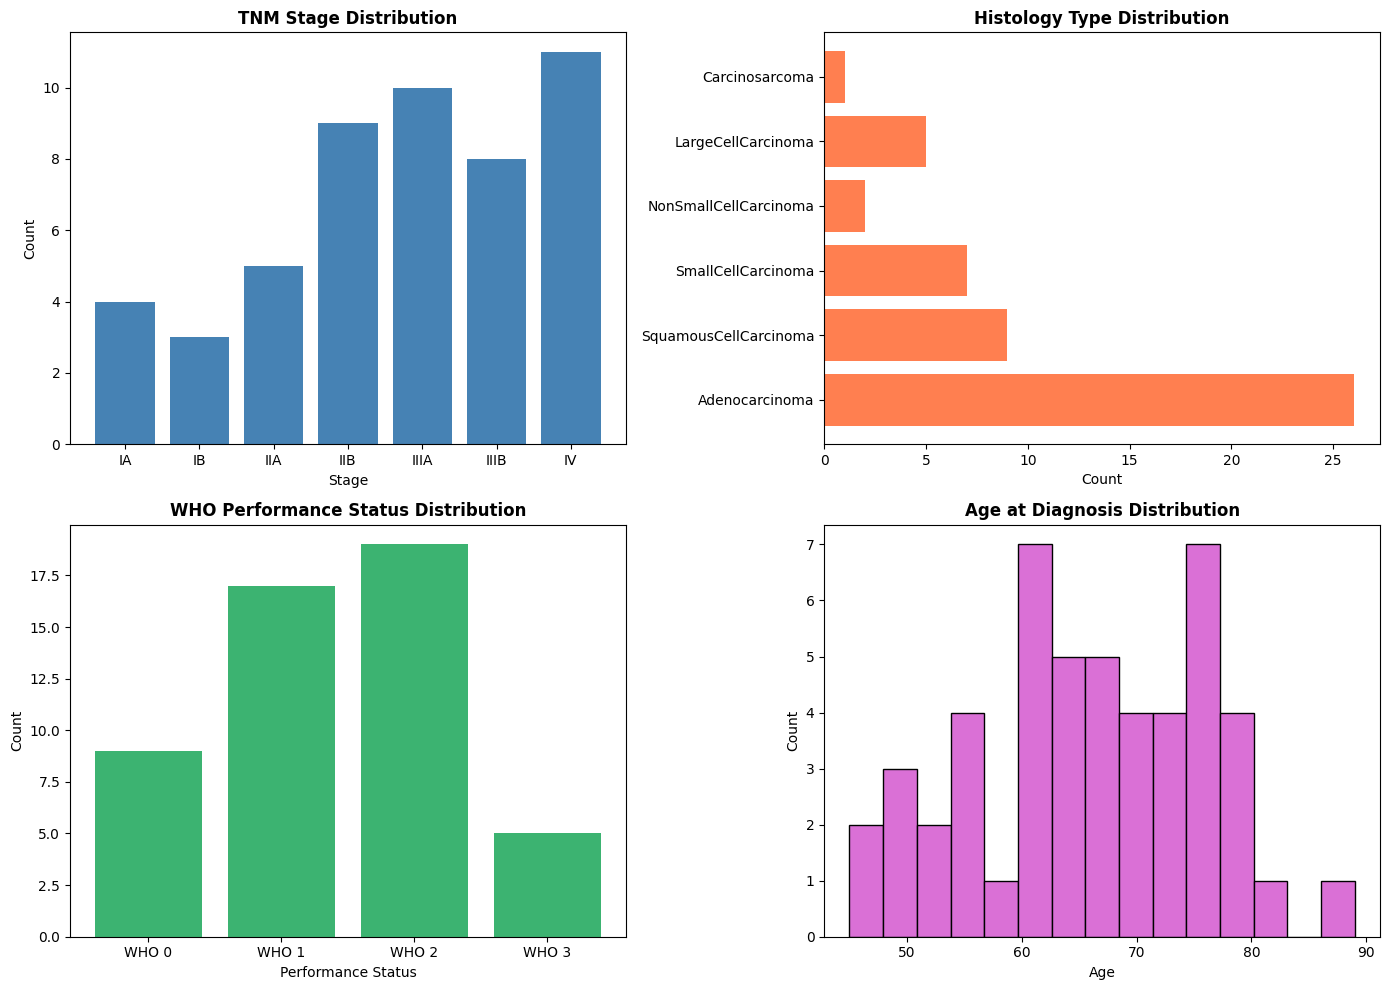

In [76]:
# Visualize patient distribution
import matplotlib.pyplot as plt

print("Patient Cohort Distribution")
print("=" * 80)

# Convert to dictionaries if needed
patient_dicts = [p.to_dict() if hasattr(p, 'to_dict') else p for p in patients]

# Calculate distributions
stage_dist = {}
histology_dist = {}
ps_dist = {}
ages = []

for p in patient_dicts:
    stage = p.get('tnm_stage', 'Unknown')
    stage_dist[stage] = stage_dist.get(stage, 0) + 1
    
    hist = p.get('histology_type', 'Unknown')
    histology_dist[hist] = histology_dist.get(hist, 0) + 1
    
    ps = p.get('performance_status', 0)
    ps_dist[ps] = ps_dist.get(ps, 0) + 1
    
    age = p.get('age_at_diagnosis', 0)
    if age > 0:
        ages.append(age)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Stage distribution
stage_order = ['IA', 'IB', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IV']
stage_counts = [stage_dist.get(s, 0) for s in stage_order]
axes[0, 0].bar(stage_order, stage_counts, color='steelblue')
axes[0, 0].set_title('TNM Stage Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Stage')
axes[0, 0].set_ylabel('Count')

# Histology distribution
hist_labels = list(histology_dist.keys())
hist_counts = list(histology_dist.values())
axes[0, 1].barh(hist_labels, hist_counts, color='coral')
axes[0, 1].set_title('Histology Type Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Count')

# Performance Status distribution
ps_labels = [f"WHO {k}" for k in sorted(ps_dist.keys())]
ps_counts = [ps_dist[k] for k in sorted(ps_dist.keys())]
axes[1, 0].bar(ps_labels, ps_counts, color='mediumseagreen')
axes[1, 0].set_title('WHO Performance Status Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Performance Status')
axes[1, 0].set_ylabel('Count')

# Age distribution
axes[1, 1].hist(ages, bins=15, color='orchid', edgecolor='black')
axes[1, 1].set_title('Age at Diagnosis Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)

---
## Part 10: Batch Processing & Cohort Analysis

In [77]:
# Batch process patients
print("Batch Patient Processing")
print("=" * 80)

batch_results = []
batch_size = min(20, len(patients))

print(f"\nProcessing {batch_size} patients...")
print("-" * 80)

for i, patient in enumerate(patient_dicts[:batch_size]):
    try:
        result = analyze_patient(patient, persist=False)
        
        batch_results.append({
            'patient_id': patient.get('patient_id', f'UNKNOWN_{i}'),
            'stage': patient.get('tnm_stage', 'Unknown'),
            'histology': patient.get('histology_type', 'Unknown'),
            'ps': patient.get('performance_status', 0),
            'scenario': result.scenario,
            'confidence': result.scenario_confidence if result.scenario_confidence is not None else 0.0,
            'num_recommendations': len(result.recommendations),
            'top_treatment': result.recommendations[0]['treatment'] if result.recommendations else 'None',
            'processing_time': result.processing_time_seconds,
            'success': result.success
        })
        
        if (i + 1) % 5 == 0:
            print(f"   Processed {i + 1}/{batch_size} patients...")
            
    except Exception as e:
        print(f"   Error processing patient {patient.get('patient_id', i)}: {e}")

print(f"\n✓ Processed {len(batch_results)} patients successfully")

# Summary statistics
if batch_results:
    avg_time = sum(r['processing_time'] for r in batch_results) / len(batch_results)
    avg_recs = sum(r['num_recommendations'] for r in batch_results) / len(batch_results)
    avg_conf = sum(r['confidence'] for r in batch_results) / len(batch_results)
    
    print(f"\nBatch Statistics:")
    print(f"   Average Processing Time: {avg_time:.3f} seconds")
    print(f"   Average Recommendations: {avg_recs:.1f}")
    print(f"   Average Confidence: {avg_conf:.2%}")
    
    # Treatment distribution
    treatment_counts = {}
    for r in batch_results:
        t = r['top_treatment']
        treatment_counts[t] = treatment_counts.get(t, 0) + 1
    
    print(f"\n   Top Treatment Distribution:")
    for treatment, count in sorted(treatment_counts.items(), key=lambda x: -x[1]):
        print(f"      {treatment}: {count} ({count/len(batch_results)*100:.1f}%)")

print("\n" + "=" * 80)

INFO:src.agents.lca_workflow:[Workflow] Running IngestionAgent...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient 18BFDF52 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient 18BFDF52 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped 18BFDF52 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient 18BFDF52...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Classified 18BFDF52 as early_stage_operable
INFO:src.agents.lca_workflow:[Workflow] Running ConflictResolutionAgent...
INFO:src.agents.conflict_resolution_agent:[ConflictResolutionAgent] Resolving conflicts for patient 18BFDF52...
INFO:src.agents.conflict_resolution_ag

Batch Patient Processing

Processing 20 patients...
--------------------------------------------------------------------------------


INFO:src.agents.lca_workflow:[Workflow] Running IngestionAgent...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient 67E3DA77 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient 67E3DA77 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped 67E3DA77 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient 67E3DA77...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Classified 67E3DA77 as sclc_extensive
INFO:src.agents.lca_workflow:[Workflow] Running ConflictResolutionAgent...
INFO:src.agents.conflict_resolution_agent:[ConflictResolutionAgent] Resolving conflicts for patient 67E3DA77...
INFO:src.agents.conflict_resolution_agent:[C

   Processed 5/20 patients...


INFO:src.agents.lca_workflow:[Workflow] Running IngestionAgent...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient 091E27B5 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient 091E27B5 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped 091E27B5 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient 091E27B5...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Classified 091E27B5 as locally_advanced_resectable
INFO:src.agents.lca_workflow:[Workflow] Running ConflictResolutionAgent...
INFO:src.agents.conflict_resolution_agent:[ConflictResolutionAgent] Resolving conflicts for patient 091E27B5...
INFO:src.agents.conflict_resolu

   Processed 10/20 patients...
   Processed 15/20 patients...


INFO:src.agents.lca_workflow:[Workflow] Running IngestionAgent...
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient 04D7DAC1 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient 04D7DAC1 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped 04D7DAC1 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient 04D7DAC1...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Classified 04D7DAC1 as sclc_limited
INFO:src.agents.lca_workflow:[Workflow] Running ConflictResolutionAgent...
INFO:src.agents.conflict_resolution_agent:[ConflictResolutionAgent] Resolving conflicts for patient 04D7DAC1...
INFO:src.agents.conflict_resolution_agent:[Con

   Processed 20/20 patients...

✓ Processed 20 patients successfully

Batch Statistics:
   Average Processing Time: 0.026 seconds
   Average Recommendations: 1.9
   Average Confidence: 80.75%

   Top Treatment Distribution:
      Surgical resection (lobectomy preferred): 5 (25.0%)
      Concurrent chemoradiotherapy + durvalumab: 4 (20.0%)
      Concurrent chemoradiotherapy: 3 (15.0%)
      Platinum-etoposide + atezolizumab: 2 (10.0%)
      Best supportive care: 2 (10.0%)
      None: 2 (10.0%)
      Pembrolizumab monotherapy (PD-L1 ≥50%): 1 (5.0%)
      SABR (stereotactic ablative radiotherapy): 1 (5.0%)



Cohort Analysis


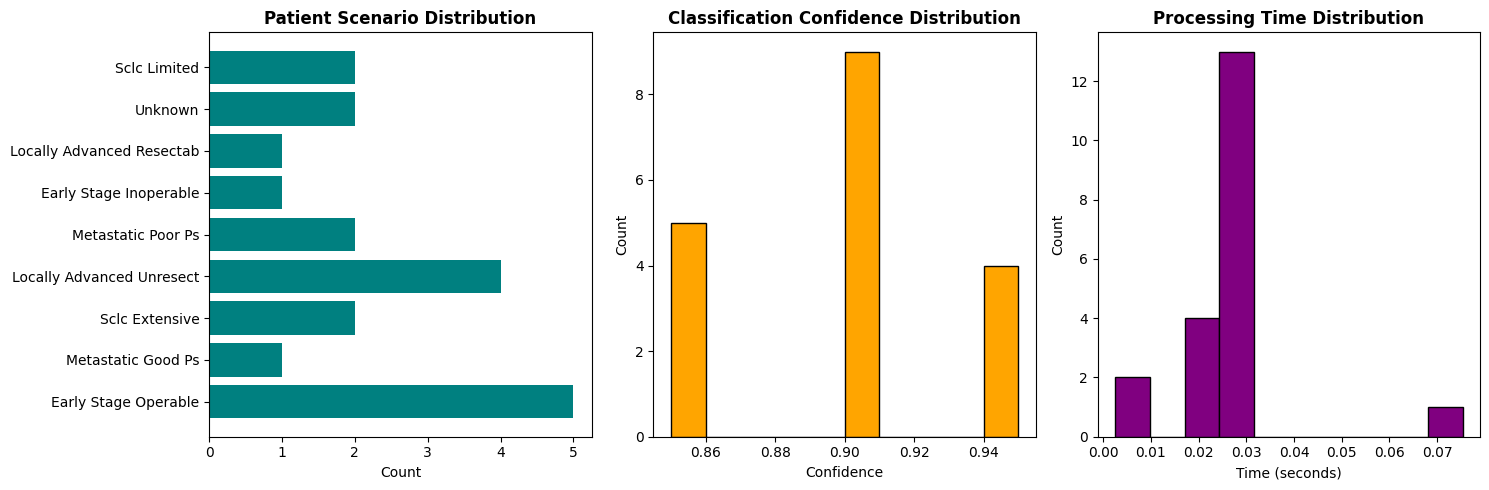

In [78]:
# Cohort Analysis Visualization
print("Cohort Analysis")
print("=" * 80)

if batch_results:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Scenario distribution
    scenario_counts = {}
    for r in batch_results:
        s = r['scenario'] or 'Unknown'
        # Shorten scenario names for display
        s_short = s.replace('_', ' ').title()[:25]
        scenario_counts[s_short] = scenario_counts.get(s_short, 0) + 1
    
    axes[0].barh(list(scenario_counts.keys()), list(scenario_counts.values()), color='teal')
    axes[0].set_title('Patient Scenario Distribution', fontweight='bold')
    axes[0].set_xlabel('Count')
    
    # Confidence distribution
    confidences = [r['confidence'] for r in batch_results if r['confidence']]
    axes[1].hist(confidences, bins=10, color='orange', edgecolor='black')
    axes[1].set_title('Classification Confidence Distribution', fontweight='bold')
    axes[1].set_xlabel('Confidence')
    axes[1].set_ylabel('Count')
    
    # Processing time distribution
    times = [r['processing_time'] for r in batch_results]
    axes[2].hist(times, bins=10, color='purple', edgecolor='black')
    axes[2].set_title('Processing Time Distribution', fontweight='bold')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)

---
## Part 11: REST API Integration

The FastAPI server provides REST endpoints for external integration.

In [73]:
print("REST API Endpoints")
print("=" * 80)

endpoints = [
    # Patient endpoints
    ("POST", "/api/v1/patients", "Create a new patient"),
    ("GET", "/api/v1/patients/{patient_id}", "Retrieve patient by ID"),
    ("POST", "/api/v1/patients/{patient_id}/analyze", "Run analysis workflow"),
    ("GET", "/api/v1/patients/{patient_id}/history", "Get treatment history"),
    
    # Treatment endpoints
    ("GET", "/api/v1/treatments/guidelines", "List all guideline rules"),
    ("POST", "/api/v1/treatments/recommend", "Generate recommendations"),
    ("GET", "/api/v1/treatments/{treatment_id}/evidence", "Get evidence details"),
    
    # Guideline endpoints
    ("GET", "/api/v1/guidelines", "List all guidelines"),
    ("GET", "/api/v1/guidelines/{rule_id}", "Get specific rule"),
    ("POST", "/api/v1/guidelines/search", "Search guidelines"),
]

print("\nAvailable Endpoints:")
print("-" * 80)

for method, path, desc in endpoints:
    print(f"   {method:6} {path}")
    print(f"          {desc}")

print("\n" + "-" * 80)
print("\nStart API Server:")
print("   uvicorn src.api.main:app --reload --port 8000")

print("\nAPI Documentation:")
print("   Swagger UI: http://localhost:8000/docs")
print("   ReDoc: http://localhost:8000/redoc")

print("\n" + "=" * 80)

REST API Endpoints

Available Endpoints:
--------------------------------------------------------------------------------
   POST   /api/v1/patients
          Create a new patient
   GET    /api/v1/patients/{patient_id}
          Retrieve patient by ID
   POST   /api/v1/patients/{patient_id}/analyze
          Run analysis workflow
   GET    /api/v1/patients/{patient_id}/history
          Get treatment history
   GET    /api/v1/treatments/guidelines
          List all guideline rules
   POST   /api/v1/treatments/recommend
          Generate recommendations
   GET    /api/v1/treatments/{treatment_id}/evidence
          Get evidence details
   GET    /api/v1/guidelines
          List all guidelines
   GET    /api/v1/guidelines/{rule_id}
          Get specific rule
   POST   /api/v1/guidelines/search
          Search guidelines

--------------------------------------------------------------------------------

Start API Server:
   uvicorn src.api.main:app --reload --port 8000

API Documenta

In [80]:
# API Request Example
print("API Request Example")
print("=" * 80)

example_api_request = {
    "endpoint": "POST /api/v1/patients/{patient_id}/analyze",
    "request_body": {
        "patient_id": "API_TEST_001",
        "name": "API_Test_Patient",
        "sex": "M",
        "age": 65,  # Use 'age' for IngestionAgent compatibility
        "tnm_stage": "IIIA",
        "histology_type": "Adenocarcinoma",
        "performance_status": 1
    }
}

print("\nRequest:")
print(f"   curl -X POST http://localhost:8000/api/v1/patients/API_TEST_001/analyze \\")
print(f"        -H 'Content-Type: application/json' \\")
print(f"        -d '{json.dumps(example_api_request["request_body"])}'")

print("\nExpected Response:")
print(json.dumps({
    "status": "success",
    "patient_id": "API_TEST_001",
    "scenario": "locally_advanced_unresectable",
    "recommendations": [
        {"rank": 1, "treatment": "Chemoradiotherapy", "evidence_level": "Grade A"}
    ],
    "processing_time_seconds": 0.25
}, indent=2))

print("\n" + "=" * 80)

API Request Example

Request:
   curl -X POST http://localhost:8000/api/v1/patients/API_TEST_001/analyze \
        -H 'Content-Type: application/json' \
        -d '{"patient_id": "API_TEST_001", "name": "API_Test_Patient", "sex": "M", "age": 65, "tnm_stage": "IIIA", "histology_type": "Adenocarcinoma", "performance_status": 1}'

Expected Response:
{
  "status": "success",
  "patient_id": "API_TEST_001",
  "scenario": "locally_advanced_unresectable",
  "recommendations": [
    {
      "rank": 1,
      "treatment": "Chemoradiotherapy",
      "evidence_level": "Grade A"
    }
  ],
  "processing_time_seconds": 0.25
}



---
## Part 12: Performance Benchmarks

In [86]:
import time

print("Performance Benchmarks")
print("=" * 80)

# Benchmark individual agents
test_patient = {
    "patient_id": "BENCH_001",
    "name": "Benchmark_Patient",
    "sex": "Male",
    "age": 65,
    "tnm_stage": "IIIA",
    "histology_type": "Adenocarcinoma",
    "performance_status": 1,
    "laterality": "Right"
}

benchmarks = {}

# Benchmark IngestionAgent
start = time.time()
for _ in range(10):
    ingestion_agent.execute(test_patient)
benchmarks['IngestionAgent'] = (time.time() - start) / 10

# Benchmark SemanticMappingAgent
patient_fact, _ = ingestion_agent.execute(test_patient)
start = time.time()
for _ in range(10):
    semantic_agent.execute(patient_fact)
benchmarks['SemanticMappingAgent'] = (time.time() - start) / 10

# Benchmark ClassificationAgent
patient_with_codes, _ = semantic_agent.execute(patient_fact)
start = time.time()
for _ in range(10):
    classification_agent.execute(patient_with_codes)
benchmarks['ClassificationAgent'] = (time.time() - start) / 10

# Benchmark ConflictResolutionAgent
classification = classification_agent.execute(patient_with_codes)
start = time.time()
for _ in range(10):
    conflict_agent.execute(classification)
benchmarks['ConflictResolutionAgent'] = (time.time() - start) / 10

# Benchmark ExplanationAgent
resolved, _ = conflict_agent.execute(classification)
start = time.time()
for _ in range(10):
    explanation_agent.execute(patient_with_codes, resolved)
benchmarks['ExplanationAgent'] = (time.time() - start) / 10

# Benchmark complete workflow
start = time.time()
for _ in range(5):
    analyze_patient(test_patient, persist=False)
benchmarks['Complete Workflow'] = (time.time() - start) / 5

# Display results
print("\nAgent Performance (average over multiple runs):")
print("-" * 80)

for agent, time_ms in benchmarks.items():
    bar_len = int(time_ms * 100)
    bar = '█' * min(bar_len, 50)
    print(f"   {agent:25} {time_ms*1000:6.2f} ms  {bar}")

total = sum(v for k, v in benchmarks.items() if k != 'Complete Workflow')
print("-" * 80)
print(f"   {'Sum of Agents':25} {total*1000:6.2f} ms")
print(f"   {'Complete Workflow':25} {benchmarks['Complete Workflow']*1000:6.2f} ms")

print("\n" + "=" * 80)

INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient BENCH_001 ingested successfully
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient BENCH_001 ingested successfully
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient BENCH_001 ingested successfully
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient BENCH_001 ingested successfully
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient BENCH_001 ingested successfully
INFO:src.agents.ingestion_agent:[IngestionAgent] Processing patient data...
INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient BENCH_001 ingested successfull

Performance Benchmarks


INFO:src.agents.ingestion_agent:[IngestionAgent] ✓ Patient BENCH_001 ingested successfully
INFO:src.agents.lca_workflow:[Workflow] Running SemanticMappingAgent...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] Mapping patient BENCH_001 to SNOMED-CT...
INFO:src.agents.semantic_mapping_agent:[SemanticMappingAgent] ✓ Mapped BENCH_001 with confidence 1.00
INFO:src.agents.lca_workflow:[Workflow] Running ClassificationAgent...
INFO:src.agents.classification_agent:[ClassificationAgent] Classifying patient BENCH_001...
INFO:src.agents.classification_agent:[ClassificationAgent] ✓ Classified BENCH_001 as locally_advanced_resectable
INFO:src.agents.lca_workflow:[Workflow] Running ConflictResolutionAgent...
INFO:src.agents.conflict_resolution_agent:[ConflictResolutionAgent] Resolving conflicts for patient BENCH_001...
INFO:src.agents.conflict_resolution_agent:[ConflictResolutionAgent] ✓ Resolved 1 conflicts for BENCH_001
INFO:src.agents.lca_workflow:[Workflow] Running ExplanationAge


Agent Performance (average over multiple runs):
--------------------------------------------------------------------------------
   IngestionAgent              2.90 ms  
   SemanticMappingAgent        3.27 ms  
   ClassificationAgent         2.46 ms  
   ConflictResolutionAgent     2.91 ms  
   ExplanationAgent            3.34 ms  
   Complete Workflow          45.80 ms  ████
--------------------------------------------------------------------------------
   Sum of Agents              14.88 ms
   Complete Workflow          45.80 ms



---
## Summary

This notebook demonstrated **complete coverage** of the Lung Cancer Assistant system:

### Components Covered:

1. **SNOMED-CT Integration** - Medical terminology with 350K+ concepts
2. **LUCADA Ontology** - Domain-specific OWL ontology (60+ classes, 95+ properties)
3. **NICE CG121 Guidelines** - 7 formalized clinical rules
4. **6-Agent Workflow Architecture**:
   - IngestionAgent (validation)
   - SemanticMappingAgent (SNOMED-CT)
   - ClassificationAgent (ontology + rules)
   - ConflictResolutionAgent (ranking)
   - PersistenceAgent (Neo4j writes)
   - ExplanationAgent (MDT summaries)
5. **Neo4j Database** - Knowledge graph storage
6. **MCP Server** - 18 external integration tools
7. **REST API** - FastAPI endpoints
8. **Batch Processing** - Cohort analysis

### Key Principles:

- **"Neo4j as a tool, not a brain"** - All medical reasoning in Python/OWL
- **Strict read/write separation** - Only PersistenceAgent writes to Neo4j
- **Complete audit trail** - Every inference tracked with provenance
- **Evidence-based recommendations** - Grade A-D evidence hierarchy

### Next Steps:

- Test with real patient data (de-identified)
- Integrate with hospital EHR systems
- Deploy MCP server for clinical use
- Expand guideline rules with latest evidence
- Add outcome tracking and learning

---

**Reference:** Sesen et al., "Lung Cancer Assistant: An Ontology-Driven Clinical Decision Support System", University of Oxford